In [1]:
import torch as tch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from toolbox import disp, disp_loss


In [2]:
# device = 'cpu'
# device = 'cuda'
# batch_size=
device = tch.device("cuda" if tch.cuda.is_available() else "cpu")

In [3]:
# input will be array in range[-1,1] 
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))
])
# should I augment the data?


train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
# Restricting to only ones.
label_mask = train_dataset.targets == 1
train_dataset.data = train_dataset.data[label_mask]
train_dataset.targets = train_dataset.targets[label_mask]

subset_size = 500  # Choose the desired subset size max size is 50000
train_subset = tch.utils.data.Subset(train_dataset, range(subset_size))
test_subset = tch.utils.data.Subset(test_dataset, range(subset_size))


batch_size = 100
train_loader = tch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader = tch.utils.data.DataLoader(test_subset, batch_size=batch_size, shuffle=False)

In [4]:
n_directions = 6
T = 1000
beta_1 = 10**-4
beta_T = 10**-2
beta_1_tensor = tch.tensor(beta_1).to(device)
height = 28
width = 28
# list containing \bar{alpha_t}
betas = tch.linspace(beta_1, beta_T, T, device=device)  # Linear schedule
alphas = 1 - betas
alphas_cumprod = tch.cumprod(alphas, dim=0)  # Cumulative product of alphas
diffusion_scheduler = alphas_cumprod

[1, 0.9999, 0.99970002, 0.9994001099940001, 0.9990003499500025, 0.9985008497750276, 0.9979017492651625, 0.9972032180406769, 0.9964054554662444, 0.9955086905563247, 0.9945131818657684, 0.9934192173657161, 0.9922271143048773, 0.990937219056281, 0.9895499069496022, 0.9880655820891778, 0.986484677157835, 0.9848076532066667, 0.9830349994308947, 0.9811672329319759, 0.979204898466112, 0.9771485681793332, 0.9749988413293387, 0.9727563439942812, 0.970421728768695, 0.9679956744467734, 0.9654788856932117, 0.96287209270184, 0.9601760508422749, 0.9573915402948322, 0.9545193656739477, 0.9515603556403585, 0.9485153625023093, 0.9453852618060516, 0.9421709519159112, 0.9388733535842055, 0.9354934095113023, 0.9320320838961105, 0.9284903619773053, 0.9248692495655938, 0.9211697725673315, 0.9173929764998054, 0.9135399259985063, 0.9096117043167128, 0.9056094128177193, 0.9015341704600397, 0.8973871132759235, 0.8931693938435266, 0.8888821807530776, 0.8845266580673875, 0.8801040247770505, 0.8756154942506875, 0.

In [6]:
# class TimeEmbedding(nn.Module):
#     def __init__(self, embed_dim: int):
#         super().__init__()
#         self.embed_dim = embed_dim

#     def forward(self, t):
#         # t: (batch_size,) - the timestep
#         # Create the sinusoidal embedding
#         half_dim = self.embed_dim // 2
#         exponents = torch.arange(half_dim, dtype=torch.float32) / half_dim
#         freqs = torch.pow(10000, -exponents).to(t.device)
#         angles = t[:, None] * freqs  # Broadcasting over the batch dimension
#         # Combine sine and cosine
#         time_embedding = torch.cat([torch.sin(angles), torch.cos(angles)], dim=-1)
#         return time_embedding  # Shape: (batch_size, embed_dim)


In [7]:
#define architecture and U-net
# Unet is predicting the noise.
#  I have image x. What image might I get if I denoise by time "timestep" in the past in given direction.


# for now the same as direction embedding
class TimeEmbedding(tch.nn.Module):
    def __init__(self, time_embedding_dimension):
        super().__init__()
        self.time_embedding = tch.nn.Linear(1, time_embedding_dimension)
    def forward(self, timestep):
        timestep = timestep.view(-1,1).float()
        return self.time_embedding(timestep)

class DirectionEmbedding(tch.nn.Module):
    def __init__(self, n_classes, direction_embedding_dimension):
        super().__init__()
        self.direction_embedding = tch.nn.Embedding(n_classes, direction_embedding_dimension)
    def forward(self, class_label):
         return self.direction_embedding(class_label)

# a block in my modified UNet
class Block(tch.nn.Module):
    def __init__(self, in_channels, out_channels, time_embedding_dimension, direction_embedding_dimension):
        super().__init__()
        self.norm = tch.nn.GroupNorm(1,out_channels)
        self.activation = tch.nn.SiLU()
        self.conv = tch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        # self.activation = tch.nn.ReLU()

        # rescale time_embedding and direction_embedding to match the dimension of the channels
        self.time_embedding_projection = tch.nn.Linear(time_embedding_dimension, in_channels)
        self.direction_embedding_projection = tch.nn.Linear(direction_embedding_dimension, in_channels)
        self.act_emb = tch.nn.SiLU()
    def forward(self, x, time_embedding, direction_embedding):
        
        batch_size, n_channels, height, width = x.shape
        # why -1 instead of n_channels?
        #  should be broadcastable to x.
        time_embedding = self.time_embedding_projection(time_embedding).view(batch_size,-1,1,1)
        direction_embedding = self.direction_embedding_projection(direction_embedding).view(batch_size,-1,1,1)
        time_embedding = self.act_emb(time_embedding)
        direction_embedding = self.act_emb(direction_embedding)
        # adding time embedding to input
        x = x+time_embedding+direction_embedding

        # forward pass
        x = self.conv(x)
        x = self.norm(x)
        x = self.activation(x)
        return x
    


In [8]:
feature1 = 64
feature2 = 128
class modifiedUnet(tch.nn.Module):
    def __init__(self, in_channels, out_channels, time_embedding_dimension, direction_embedding_dimension, n_classes):
        super().__init__()

        self.time_embedding = TimeEmbedding(time_embedding_dimension)
        self.direction_embedding = DirectionEmbedding(n_classes, direction_embedding_dimension)
        self.pool = tch.nn.MaxPool2d(kernel_size=2, stride=2)


        self.block1 = Block(in_channels, feature1, time_embedding_dimension,direction_embedding_dimension)
        # maxpool
        self.block2 = Block(feature1, feature2, time_embedding_dimension,direction_embedding_dimension)
        # maxpool
        self.block3 = Block(feature2, feature2, time_embedding_dimension,direction_embedding_dimension)
        
        # upsample
        self.up1 = tch.nn.ConvTranspose2d(feature2,feature2, kernel_size=2, stride=2)

        self.block4 = Block(feature2, feature1, time_embedding_dimension,direction_embedding_dimension)
        
        # upsample
        self.up2 = tch.nn.ConvTranspose2d(feature1,feature1, kernel_size=2, stride=2)
        
        self.block5 = Block(feature1, out_channels, time_embedding_dimension,direction_embedding_dimension)



    def forward(self, x, class_label, timestep):
        time_embedding = self.time_embedding(timestep)
        direction_embedding = self.direction_embedding(class_label)

    # no skip connections for now
        x1 = self.block1(x,time_embedding,direction_embedding)
        # downsample
        x1_reduced = x1.clone()
        x1 = self.pool(x1)
        x2 =  self.block2(x1,time_embedding,direction_embedding)
        x2_reduced = x2.clone()
        # downsample
        x2 = self.pool(x2)
        x3 =  self.block3(x2,time_embedding,direction_embedding)
        # upsample
        x3 = self.up1(x3)
        # skip connection below
        x3 = x3+x2_reduced
        x4 = self.block4(x3,time_embedding,direction_embedding)


        # upsample
        x4 = self.up2(x4)
        # skip connection below
        x4 = x4+x1_reduced
        x5 = self.block5(x4, time_embedding, direction_embedding)
        return x5



In [9]:
modifiedUnet = modifiedUnet(
    in_channels=1, 
    out_channels=1,
    time_embedding_dimension=32,
    direction_embedding_dimension=32, 
    n_classes=10).to(device)
#weights, loss function, optimizer


# Instantiate the model
# optimizer and scheduler
optimizer = tch.optim.AdamW(modifiedUnet.parameters(), lr=1e-3,
                            weight_decay=1e-4)
scheduler = tch.optim.lr_scheduler.StepLR(optimizer, step_size=10000,
                                          gamma=0.2)
loss_func = tch.nn.MSELoss(reduction='mean')


total_params = sum(p.numel() for p in modifiedUnet.parameters())

print(f"modifiedUnet has {total_params:,} parameters.")


modifiedUnet has 392,613 parameters.


In [116]:
import time

def estimate_remaining_time(start_time, current_epoch, total_epochs):
    """Estimates the remaining training time.

    Args:
        start_time: The start time of the training process.
        current_epoch: The current epoch number.
        total_epochs: The total number of epochs.

    Returns:
        None
    """
    elapsed_time = time.time() - start_time
    time_per_epoch = elapsed_time / (current_epoch + 1)
    remaining_time = time_per_epoch * (total_epochs - current_epoch - 1)
    remaining_hours = int(remaining_time // 3600)
    remaining_minutes = int((remaining_time % 3600) // 60)
    remaining_seconds = int(remaining_time % 60)
    print(f"Estimated remaining time: {remaining_hours:02d}:{remaining_minutes:02d}:{remaining_seconds:02d}")

In [128]:
#training
running_loss = 0.0
epoch_loss_ = 0.0
epoch_loss = 0.0
n_epoch = 100

 
for epoch in range(n_epoch):
    i = 0
    for data in train_loader:
        ###### COMPLETER ICI ######
        start_time = time.time()
        loss_val = 0 # requis aux lignes suivantes
        images,labels = data
        images, labels = images.to(device), labels.to(device)
        
        timesteps = tch.randint(1, T, size=(batch_size,), device=device)  # Move timesteps to the device
        # generating a batch of random noise

        noise = tch.randn(batch_size, 1, height, width, device=device)
        alpha_bar = diffusion_scheduler[timesteps].view(-1,1,1,1).to(device)
        noised_image = tch.sqrt(alpha_bar)*images+tch.sqrt(1-alpha_bar)*noise
        predicted_noise = modifiedUnet(noised_image,labels, timesteps)
        loss_val = loss_func(noise, predicted_noise)
        ## Gradient calculation
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()
        #####

        running_loss += loss_val.item()
        epoch_loss += loss_val.item()
    print(f"epoch= {epoch}", end="\r", flush=True)
    if epoch % 10 == 0:    # every 100 epoch...
        disp_loss(epoch_loss, epoch)
        estimate_remaining_time(start_time, epoch, n_epoch)

    i = i+1
    epoch_loss = 0.0
    scheduler.step()  
print("Finished training")
#save the model weights after training
tch.save(modifiedUnet.state_dict(), 'model_weights.pth')


Epoch: 10 -- Total loss: 50.00442
Finished training


In [ ]:
# loading model from weights
state_dict = tch.load("model_weights.pth")

# Load the state dictionary into the model
modifiedUnet.load_state_dict(state_dict)

modifiedUnet = modifiedUnet.to(device)

# Set the model to evaluation mode
modifiedUnet.eval()

In [129]:
def normalize_data(images):
    # for each image take a maximu of absolute values. Look at channels, height and width
    # thus each image gets scaled individually
    max_vals = tch.amax(tch.abs(images), dim=(1, 2, 3), keepdim=True)
    # images are between [-1,1]
    images = images/max_vals
    return images
# how to generate image from noise
# algorith from DDPM paper
def generate_image(n_images, labels, noise_predictor, device=device):
    labels = tch.tensor(labels).to(device)
    images = tch.randn(n_images, 1, height, width).to(device)
    images = normalize_data(images)
    i = T - 1  
    while i >= 0:  
        times = tch.tensor([i] * n_images).to(device)
        alpha_bar = diffusion_scheduler[i].to(device)
        if i > 0:  
            noise = tch.randn(n_images, 1, height, width).to(device)
        else:
            noise = images * 0
        images = (1 / tch.sqrt(alphas[i])) * (images - (1 - alphas[i]) / tch.sqrt(1 - diffusion_scheduler[i]) * noise_predictor(images, labels, times)) + tch.sqrt(betas[i]) * noise
        images = normalize_data(images)
        i = i - 1  # Decrement i for the next iteration
    return images.detach().cpu().numpy()

(<Figure size 850.394x141.732 with 6 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>]], dtype=object))

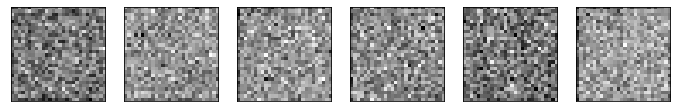

In [130]:
images = generate_image(n_images=6, labels=[1,2,3,4,5,6], noise_predictor=modifiedUnet).squeeze(1)
disp(images, shape = (1,6), scale=1)